In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
from obj_spec import multi_data

opt = torch.load('./opt.pth')
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
opt.dataset='pascal'
opt.input_res=512
opt.task='ctdet'
opt.multi_res=True
val_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'val'),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

if opt.multi_res:
  train_loader=multi_data()
else:
    train_loader = torch.utils.data.DataLoader(
        Dataset(opt, 'train'),
        batch_size=opt.batch_size,
        shuffle=True,
        num_workers=opt.num_workers,
        pin_memory=True,
        drop_last=True
    )


heads {'hm': 20, 'wh': 2, 'reg': 2}
==> initializing pascal test2007 data.
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loaded val 4952 samples
==> initializing pascal trainval0712 data.
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Loaded train 16551 samples


In [2]:
from models.model import create_model
heads = {'hm': 20,'wh': 2,'reg': 2 }
model = create_model('resdcn_101',heads ,64)
state_dict=torch.load('/home/mayx/project/github/CenterNet/exp/ctdet/pascal_resnet101_original_hm_ma/model_last.pth')
for k,v in state_dict.items():
    print(k)
params=state_dict['state_dict']
model.cuda(2)
model.load_state_dict(params)

=> loading pretrained model https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
=> init deconv weights from normal distribution
epoch
state_dict
optimizer


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

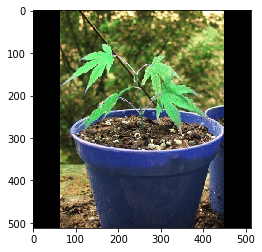

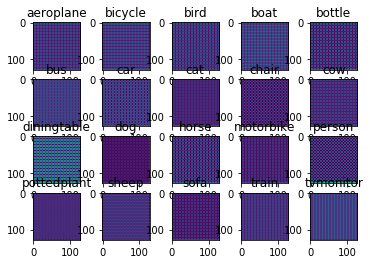

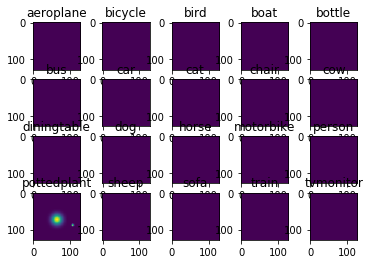

KeyboardInterrupt: 

In [3]:
from models.utils import _sigmoid
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
def draw_pic_hm(data,batch_output,batch_hm):
    classes=["aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
"horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
"train", "tvmonitor"]
    for pic,output,hm in zip(data,batch_output,batch_hm):
        plt.imshow(((pic.permute((1,2,0))*std+mean)*255).int())
        plt.show()
        for index,(out_hm) in enumerate(output):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(out_hm)
        plt.show()
        for index,(label_hm) in enumerate(hm):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(label_hm)
        plt.show()
model.eval()
for index,batch in enumerate(train_loader):
    data=batch['input'][:2]
    if data.shape[3]!=512:
        continue
    data=data.cuda(2)
    output,=model(data)
    draw_pic_hm(data.cpu().detach(),_sigmoid(output['hm'].cpu().detach()),batch['hm'][:1].cpu().detach())
#     print(output['wh'],output['wh'].shape)
#     print(output['reg'],output['reg'].shape)
#     print(batch['reg_mask'][:1],batch['reg_mask'][:1].shape)
    input('s')

In [ ]:
print(batch['wh'][1])
print(batch['ind'][1])
print(batch['reg_mask'][3])
print(output['wh'][1])
# input('S')
# wh=output['wh'][0]
# print(wh)
# wh=wh.view(2,-1)
# print(wh[:,6083])
# print(wh.shape)
          

In [ ]:
from models.losses import RegL1Loss, RegLoss, NormRegL1Loss, RegWeightedL1Loss
crit_reg = RegL1Loss()
crit_reg(output['wh'][:2], batch['reg_mask'][:2].cuda(2),batch['ind'][:2].cuda(2), batch['wh'][:2].cuda(2))